<a href="https://colab.research.google.com/github/chrishare/colab_deeplearning/blob/master/conv_autoencoder_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
"""
This listing will build a convolutional autoencoder on the MNIST dataset,
with code taken from https://blog.keras.io/building-autoencoders-in-keras.html

The purpose of this listing is to explain exactly what the code is doing. These
are just notes for myself based on my current understanding. Hopefully I can
come back to these later when I better understand what is happening.

We really want to run this on a GPU. It is going to run 5x times faster than
on CPU, atleast when run on Colab. I think this is because the number of 
operations that can be accelerated on the GPU here are significant, including
the convolution operations.

We're using Keras so we need various layers:
Input - The input features (just 1 of these)
Dense - Dense, fully-connected layers
Conv2D - Overlaying our image matrix (for a channel) with a convolutional
kernel, and then performing elementwise multiplication and summing to get the
result. We repeat this many times by sliding the kernel across the input matrix
abd end up with an output matrix for further processing. We don't necessarily 
slide (stride) the full length or width of the kernel.
We do this to efficiently transform (sharpen, blur, do edge detection,
etc) the feautrespace before doing regular neural net processing. Some common
kernels are here: https://en.wikipedia.org/wiki/Kernel_(image_processing).
MaxPooling2D - Similar to Conv2D, but takes the maximum value of the
intersection between the two areas. Usually, we will stride the width/length
of the pooling kernel, so that we'll never overlap. This is because the purpose
of this operation is basically to downsample the image. This gives us a few
benefits - it reduces computation costs by reducing dimensionality, and also
helps prevent overfitting by 'abstracting' out low-level details in the input.
UpSampling2D - Achieves basically the reverse of what MaxPooling2D does.

Of these layers, MaxPooling2D and UpSampling2D are not trained - they don't 
have parameters or weights, they just perform the operation they need to.
Conv2D layers are indeed trained. The kernel values are trained such that the
NN can determine what kind of convolution is best - what kind of edges and
shapes are valuable, and so on.

You'll see two different kinds of padding:
Same = Add zeros to the side of the input to make it big enough to perform
the final convolutions.
Valid - Don't pad - just drop the final operation / elements.

Another argument to the Conv2d etc layers is the number of filters. This arg,
say 10, means we will have 10 'channels' or stacked filters, that are trained
independantly - this means we can run many kinds of shape detector / transform
on the same image / input. It will also mean the output has 10 x dimensions.

We may want to perform stacks of convolution and pooling operations - not just
one. This is thought to be biologically plausible, at least in that many layers
of low level operations seem to run as preprocessing before richer processing
is done.

We also want to import the Keras backend in order to use backend e.g.
Tensorflow primitives (operations) directly, such as mean and exp.
"""
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

# MNIST is 28x28 with just one channel. Channels are usually for colour but
# can also represent other kinds of data, like heatmap information.
input_img = Input(shape=(28, 28, 1))  

""" We define first our NN that goes from the input image to the encoded
representation. Generally we are using rectified linear units as the activation
but use sigmoid on the final layer decoder layer to get back to a probability
estimate.
"""

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded)

""" You will get these shapes.
Tensor("conv2d_29/Relu:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("max_pooling2d_13/MaxPool:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("conv2d_30/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("max_pooling2d_14/MaxPool:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("conv2d_31/Relu:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("max_pooling2d_15/MaxPool:0", shape=(?, 4, 4, 8), dtype=float32)

The encoded layer has 4 * 4 * 8 = 128 dimensions, but that doesn't mean that
all of those dimensions will be used, especially if we penalise activation.

Encoded represents our latent space. It's our 'compressed' feature space.
At this point the representation is (4, 4, 8) i.e. 128-dimensional
We now have to reverse the process back up to a digit.

I have read that it is a good idea to to tie weights in equivalent layers from
the encode and decode halves. That is, we tell Keras etc that the encode and 
decode layers will share weights with their counterparts. This involves taking 
a transpose of the weights from the encode layer and using them in the decoder.
This means fewer parameters to learn, making it faster and less likely to 
overfit. We don't take this approach here. You can see information here:
https://amiralavi.net/blog/2018/08/25/tied-autoencoders
"""
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x)
x = UpSampling2D((2, 2))(x)
print(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x)
x = UpSampling2D((2, 2))(x)
print(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
print(x)
x = UpSampling2D((2, 2))(x)
print(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded)

""" You will get these shapes:

Tensor("up_sampling2d_16/ResizeNearestNeighbor:0", shape=(?, 8, 8, 8), dtype=float32)
Tensor("conv2d_40/Relu:0", shape=(?, 8, 8, 8), dtype=float32)
Tensor("up_sampling2d_17/ResizeNearestNeighbor:0", shape=(?, 16, 16, 8), dtype=float32)
Tensor("conv2d_41/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("up_sampling2d_18/ResizeNearestNeighbor:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("conv2d_42/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)

Finally, let's construct a model with these layers and optomize on the entropy
loss between the original and the reconstruction.
"""
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Tensor("conv2d_43/Relu:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("max_pooling2d_19/MaxPool:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("conv2d_44/Relu:0", shape=(?, 14, 14, 8), dtype=float32)
Tensor("max_pooling2d_20/MaxPool:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("conv2d_45/Relu:0", shape=(?, 7, 7, 8), dtype=float32)
Tensor("max_pooling2d_21/MaxPool:0", shape=(?, 4, 4, 8), dtype=float32)
Tensor("conv2d_46/Relu:0", shape=(?, 4, 4, 8), dtype=float32)
Tensor("up_sampling2d_19/ResizeNearestNeighbor:0", shape=(?, 8, 8, 8), dtype=float32)
Tensor("conv2d_47/Relu:0", shape=(?, 8, 8, 8), dtype=float32)
Tensor("up_sampling2d_20/ResizeNearestNeighbor:0", shape=(?, 16, 16, 8), dtype=float32)
Tensor("conv2d_48/Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Tensor("up_sampling2d_21/ResizeNearestNeighbor:0", shape=(?, 28, 28, 16), dtype=float32)
Tensor("conv2d_49/Sigmoid:0", shape=(?, 28, 28, 1), dtype=float32)


In [0]:
# Let's import the MNIST dataset, which will download from the net
from keras.datasets import mnist
import numpy as np

# Extract the data. Here, we do not care about the labels.
(x_train, _), (x_test, _) = mnist.load_data()

# Scale to get a 0..1 float of pixel intensity. No 0 centreing or norm here.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape to be 28*28*1 instead of 28*28, as required by our layers.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

In [33]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 132us/step - loss: 0.2225 - val_loss: 0.1755
Epoch 2/50
60000/60000 [==============================] - 7s 118us/step - loss: 0.1586 - val_loss: 0.1489
Epoch 3/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1414 - val_loss: 0.1312
Epoch 4/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1321 - val_loss: 0.1276
Epoch 5/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1266 - val_loss: 0.1261
Epoch 6/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1228 - val_loss: 0.1216
Epoch 7/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1199 - val_loss: 0.1165
Epoch 8/50
60000/60000 [==============================] - 7s 118us/step - loss: 0.1172 - val_loss: 0.1165
Epoch 9/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1157 - val_loss: 0.1

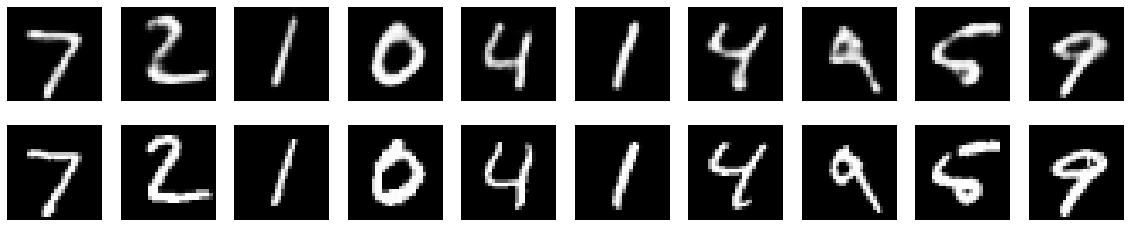

In [39]:
# Import matplotlib for data visualisation
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

# We're going to print 2 rows, 10 columns of images - the top row will have 
# originals and the bottom will have the reconstruction
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    # Don't show axes 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    # Don't show axes 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# Actually show the plot
plt.show()